<a href="https://colab.research.google.com/github/aluthfian/earth_engine_trial/blob/main/temperature_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee

ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=7t_4tUrs5CWcAXmS215rc6t2wSFTxlJJVJtcywtUid0&tc=tJLMcPY2-7HQNciyLB6xt8jGaNTRxfQoH033X1Dgv7w&cc=Jm90shwj2iFfJ0IU8IcGoInBCXB91TW_iYPFlwULZe8

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWj84PkqZJHN51qTUJuyC3X3S5DA0HXsyjpCsgaeTAlpAXqfYb0RGrE

Successfully saved authorization token.


In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import folium
from folium import plugins
import branca
from branca.element import Figure
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta

In [116]:
country_bound = ee.FeatureCollection("USDOS/LSIB/2017")\
.filter(ee.Filter.eq('COUNTRY_NA', 'Indonesia')).geometry()

#latitude = -43.5320
#longitude = 172.6306

latitude = -6.2232
longitude = 106.8411

point_loc = ee.Geometry.Point([longitude, latitude])

temp_channel = 'Tair_f_inst'

wx_data = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H')\
.select(temp_channel)

commence_date = datetime(2001,1,1)
final_date = datetime(2021,12,31)
weekly_date = np.arange(commence_date, final_date, timedelta(days=7)).astype(datetime)

print(type(weekly_date[9].strftime("%Y-%m-%d")))

<class 'str'>


In [117]:
def mean_temp(startDate, endDate):
  start_Date = startDate.strftime("%Y-%m-%d")
  end_Date = endDate.strftime("%Y-%m-%d")
  temp_mean = ee.Image(wx_data.filterDate(start_Date, end_Date).mean())\
  .subtract(273.15)
  temp_mean = temp_mean.reduceRegion(**{
      'reducer': ee.Reducer.mean(),
      'geometry': point_loc,
      'scale': 10000,  # meters
  })
  temp_mean_val = temp_mean.getInfo()[temp_channel]
  return temp_mean_val

In [ ]:
len_final_data = len(weekly_date)-1
final_data = []
timestamp = []

for i in range(len_final_data):
  startDate = weekly_date[i]
  endDate = weekly_date[i+1]
  final_data.append(mean_temp(startDate, endDate))
  timestamp.append(startDate+timedelta(days=3))

#print(final_data)

In [119]:
def trend_func(x, a, b, c, d, e):
    return a * np.sin(b * x) + c * np.cos(d * x) + e

megaseconds_data = np.array([(date-datetime(2001,1,1)).total_seconds()/1e6 for date in timestamp])
params, params_covariance = optimize.curve_fit(trend_func, megaseconds_data, final_data, p0=[20, 2, 10, 1, 15])

Text(0.5, 1.0, 'Variasi suhu udara di DKI Jakarta')

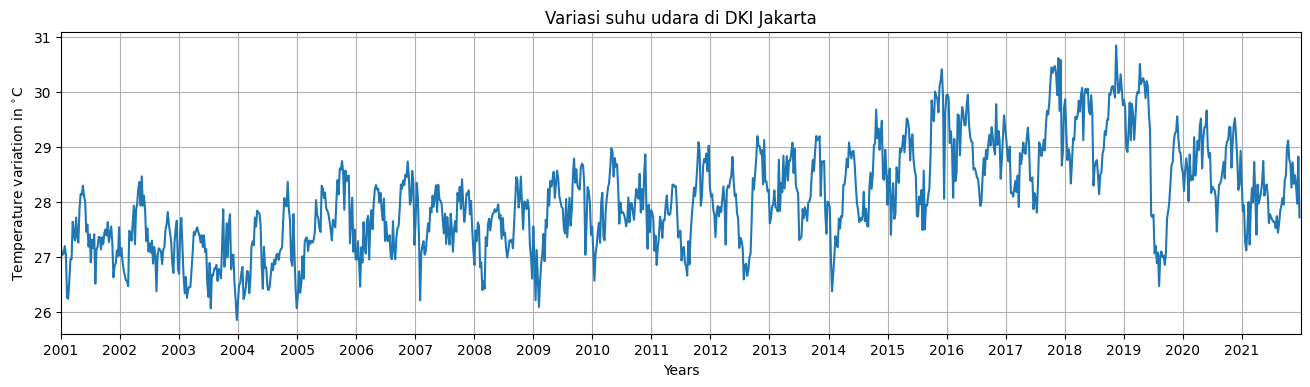

In [121]:
fig, ax1 = plt.subplots(figsize=(16, 4), dpi=100, facecolor='white')
ax1.plot(timestamp, final_data)
#ax1.plot(timestamp, trend_func(megaseconds_data, params[0], params[1], params[2], params[3], params[4]), label='Fitted function')
ax1.set_xlim([date.fromisoformat('2001-01-01'), date.fromisoformat('2022-01-01')])
yearly_date = np.arange(np.datetime64("2001-01"), np.datetime64("2022-01"), np.timedelta64(1,"Y")).astype(datetime)
years = yearly_date.astype('datetime64[Y]').astype(int) + 1970
ax1.set_xticks(yearly_date)
ax1.set_xticklabels(years)
ax1.set_xlabel('Years')
ax1.set_ylabel('Temperature variation in $^{\circ}$C')
ax1.grid(True)
ax1.set_title('Variasi suhu udara di DKI Jakarta')